In [595]:
# Copyright 2008, Fredrik Lundh

import re, htmlentitydefs
import unidecode
##
# Removes HTML or XML character references and entities from a text string.
#
# @param text The HTML (or XML) source text.
# @return The plain text, as a Unicode string, if necessary.

def unescape(text):
    def fixup(m):
        text = m.group(0)
        if text[:2] == "&#":
            # character reference
            try:
                if text[:3] == "&#x":
                    return unichr(int(text[3:-1], 16))
                else:
                    return unichr(int(text[2:-1]))
            except ValueError:
                pass
        else:
            # named entity
            try:
                text = unichr(htmlentitydefs.name2codepoint[text[1:-1]])
            except KeyError:
                pass
        return text # leave as is
    return re.sub("&#?\w+;", fixup, text)

In [24]:
import requests
import pandas as pd
import numpy as np
import re
from dateutil.parser import parse
from random import randint
from time import sleep
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from __future__ import division
import collections
from collections import Counter
from sklearn import grid_search, decomposition
import pickle
import json
from pymongo import MongoClient
client = MongoClient()
# To Plot matplotlib figures inline on the notebook
%matplotlib inline
from textblob import TextBlob
from textblob.np_extractors import ConllExtractor, FastNPExtractor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [1078]:

def blobextract(text):
    blob = TextBlob(text, np_extractor=extractor)
    return blob.noun_phrases
def split_into_lemmas(message):
    words = []
    message = unidecode.unidecode(message)
    message = TextBlob(message).lower()
    for i in message.words:
        if len(i)>1:
            words.append(i)
    #words2 = blobextract(message)
    #result = words2 + words
    # for each word, take its "base form" = lemma 
    return words


In [307]:
data = pd.read_pickle('sampledata.pickle')

In [332]:
for i in range(1, 11):
    name = 'data'+str(i)+'.pickle'
    if i == 1:
        data = pd.read_pickle(name)
    else:
        new = pd.read_pickle(name)
        data = pd.concat([data, new])

In [20]:
extractor = FastNPExtractor()
#blob = TextBlob(data['text'][0], np_extractor=extractor)
#blob.noun_phrases
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
from textblob import Word
from textblob.parsers import PatternParser
blob = TextBlob(data['text'][0], np_extractor=extractor)

In [407]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [969]:
n_features = 1000
n_topics = 70
n_top_words = 50

In [614]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, tokenizer= split_into_lemmas,
                                   #max_features=n_features, 
                                   stop_words='english')

In [615]:
tfidf = tfidf_vectorizer.fit_transform(data.text)

In [970]:
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

In [971]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0:
mr said interview christie told campaign office added did news wednesday governor later president years tuesday called new statement lawyer
Topic #1:
trump donald republican campaign mr candidate presidential hillary nominee convention clinton debate pence speech supporters america n't immigration voters party
Topic #2:
company said companies billion million business executive chief year sales deal percent industry new market employees customers quarter price revenue
Topic #3:
team game season players league coach games n.f.l teams said football player play quarterback yards goal cup soccer played fans
Topic #4:
percent rose cents fell stocks oil index prices crude investors stock barrel yen points dow ounce shares market gained price
Topic #5:
clinton mrs campaign hillary voters emails democratic email secretary debate state election presidential president server f.b.i comey kaine polls aides
Topic #6:
obama president white administration house cuba american states united wa

In [972]:
topics = []
for topic in nmf.components_:
    topics.append( "-".join([tfidf_feature_names[i] for i in topic.argsort()[:-6:-1]]))

[u'mr-said-interview-christie-told',
 u'trump-donald-republican-campaign-mr',
 u'company-said-companies-billion-million',
 u'team-game-season-players-league',
 u'percent-rose-cents-fell-stocks',
 u'clinton-mrs-campaign-hillary-voters',
 u'obama-president-white-administration-house',
 u'police-officers-officer-said-department',
 u'graduated-bride-groom-father-university',
 u'zika-virus-mosquito-mosquitoes-pregnant',
 u'china-chinese-beijing-hong-kong',
 u'european-britain-union-british-europe',
 u'p.m-york-new-times-a.m',
 u'bank-banks-financial-deutsche-banking',
 u'points-scored-rebounds-assists-lead',
 u'economy-growth-fed-economic-percent',
 u'iran-nuclear-iranian-sanctions-tehran',
 u'korea-north-nuclear-korean-south',
 u'water-flint-lead-snyder-residents',
 u'gay-transgender-rights-law-gender',
 u'women-men-woman-female-abortion',
 u'ms-said-rousseff-woman-mother',
 u'islamic-syria-state-united-government',
 u'apple-iphone-f.b.i-encryption-government',
 u'fund-investors-funds-hedg

In [974]:
doctopic = nmf.transform(tfidf)


In [1092]:
foo = pd.DataFrame(doctopic)
foo.columns = topics

In [976]:
weights = [nmf.components_[1][i] for i in nmf.components_[1].argsort()[:-n_top_words - 1:-1]]
words = [tfidf_feature_names[i] for i in nmf.components_[1].argsort()[:-n_top_words - 1:-1]]

In [977]:
zip (weights, words)

[(7.9235179782286682, 'trump'),
 (0.93504019607958533, 'donald'),
 (0.8129886312854504, 'republican'),
 (0.70631346628549441, 'campaign'),
 (0.52998634067094852, 'mr'),
 (0.37600624397622806, 'candidate'),
 (0.37012471224810312, 'presidential'),
 (0.35376914103341356, 'hillary'),
 (0.34515866917937338, 'nominee'),
 (0.34193983496966984, 'convention'),
 (0.33965625417272011, 'clinton'),
 (0.33808433819074846, 'debate'),
 (0.31314273025889072, 'pence'),
 (0.24425970079572784, 'speech'),
 (0.2325391832882592, 'supporters'),
 (0.22979049717744388, 'america'),
 (0.2111881286491373, "n't"),
 (0.20195609099347683, 'immigration'),
 (0.20194197232267477, 'voters'),
 (0.19928979885982817, 'party'),
 (0.19417004027718568, 'romney'),
 (0.19203879146157243, 'immigrants'),
 (0.18118945593716468, 'news'),
 (0.17503223189313635, 'rally'),
 (0.17451525372807006, 'republicans'),
 (0.17318920043618097, 'ryan'),
 (0.16659153197658116, 'states'),
 (0.16577007763111268, 'american'),
 (0.16335371042265143, '

In [1093]:
foo.index = data.title

In [1094]:

foo[foo>0.008] = 1
foo[foo<=0.008] = 0

In [1095]:
sumtopic = pd.DataFrame(foo.sum())

In [1096]:
sumtopic = sumtopic.sort_values(by = 0, ascending=False)

In [1108]:
toptopic.columns = ['# of articles']

In [1103]:
toptopic.index = ['general', 'politics', 'business', 'gender issue', 'US-Syria', 'NY local', 'supreme court',
                 'police-shooting', 'sports', 'NY housing', 'election', 'human-interest', 'books', 'social media usage',
                 'medicine/healthcare', 'economy', 'obama white house']

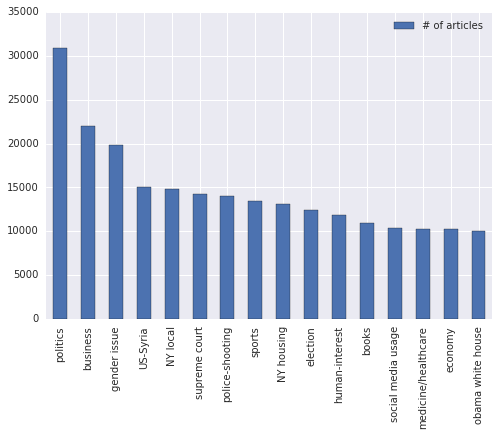

In [1109]:
import seaborn as sns
toptopic.plot(kind = 'bar')

In [321]:
data['pubdate'] = data.pubdate.apply(parse)

In [353]:
pickle.dump(nmf, open('nmf_model.p', "wb" ))

### Finding sentence importance for any given article

In [1059]:
document = data.loc[19397]['text']

data.loc[19397]['title']

u'The Sins of the Chicago Police Laid Bare'

In [1060]:
#transform document into existing nytimes tfidf space
mew = tfidf_vectorizer.transform([document])

#transform vectorized document into topic space
mu = nmf.transform(mew)[0]

In [1075]:
mu.shape

(70,)

In [1063]:
#get index of top topics
b = mu.argsort()[::-1]
num = len(mu[mu>=0.008])
topic2word = [{} for _ in range(num)]
topicw = np.zeros(num)
z = 0
#make dictionary of words to weight for each top topic
for ind, i in enumerate(b[:num]):
    if i == 0:
        z = 1
        print ('general interest')
    else:
        print (topics[i], mu[i])
        weights = nmf.components_[i][nmf.components_[i]>0]
        words = np.array(tfidf_feature_names)[nmf.components_[i]>0]
        dic = zip(words, weights)
        topic2word[ind-z] = dict((x, y) for x, y in dic)
        topicw[ind-z] = mu[i]
topicw = topicw/np.max(topicw)

(u'police-officers-officer-said-department', 0.086700930480897706)
(u'city-blasio-mayor-housing-new', 0.01699146873268868)
(u'percent-rose-cents-fell-stocks', 0.010940270957008899)


In [1073]:
n_top_sen = 5
document = unidecode.unidecode(document)
blob = TextBlob(document).lower()
sentence_score = []

for j in blob.sentences:
    score = 0
    for i in set(j.words):
        for ind, topic in enumerate(topic2word):
            if i in topic.keys():
                score += topic[i]#*topicw[ind]
    if len(j.words) >= 10:
        #print j
        #print score/len(j.words)
        sentence_score.append(score/len(j.words))
    else:
        #print j
        #print 'too short!!'
        sentence_score.append(0)




In [1074]:
sentence_score = np.array(sentence_score)
print [(blob.sentences[i], sentence_score[i]) for i in sentence_score.argsort()[:-n_top_sen - 1:-1]] 


[(Sentence("-- two cities where police killings of civilians have provoked deep public outrage."), 0.46294996038357455), (Sentence("when police officers fired their tasers, african-americans were targeted 76 percent of the time, compared with 13 percent for hispanics and 8 percent for whites."), 0.41400471431956376), (Sentence("african-americans, who make up only one-third of the city's population, made up nearly three-quarters of the people who were shot by police officers between 2008 and 2015, compared with 14 percent for hispanics and 8 percent for whites."), 0.3860942732976439), (Sentence("the video contradicted a police news release saying that the young man was killed because he had been menacing the officer."), 0.36252470259923292), (Sentence("mayor emanuel created the task force in december, not long after the city released a police video showing a white police officer, jason van dyke, executing a black teenager named laquan mcdonald on a street on the south side of chicago.")

In [911]:
print [sentence_score[i] for i in sentence_score.argsort()[:-n_top_sen - 1:-1]]

[0.65243512802800263, 0.28015449090357175, 0.22818006496079343, 0.21672426508851741, 0.19033030697350153]


In [1077]:
pickle.dump(nmf, open( "nmf_model.p", "wb" ) )
pickle.dump(tfidf_vectorizer, open('tfidf.p', 'wb'))

In [1079]:
pickle.dump(topics, open('topics.p', 'wb'))